In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from utils.losses import heatmap_mse_loss
from utils.pckh import compute_pckh
from utils.heatmaps import heatmaps_to_coords
from utils.visualisations import visualize_batch_predictions
from data.mpii_dataset import MPIIDataset
from models.model import ViTPoseHeatmap

Downloading: "https://huggingface.co/shai-hulud/AIML339Capstone/resolve/main/vit_small_lora_20e_5e-4.pth" to /Users/kayden/.cache/torch/hub/checkpoints/vit_small_lora_20e_5e-4.pth


100%|██████████| 93.6M/93.6M [00:04<00:00, 23.0MB/s]


✅ Test Loss: 0.0020, PCKh@0.5: 0.7237


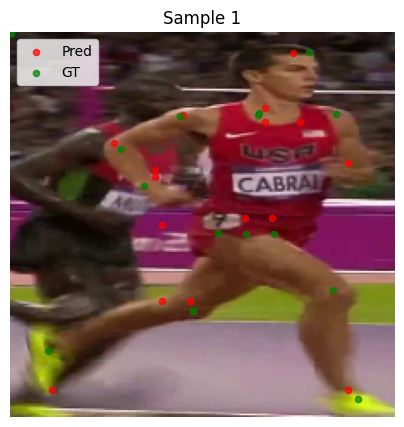

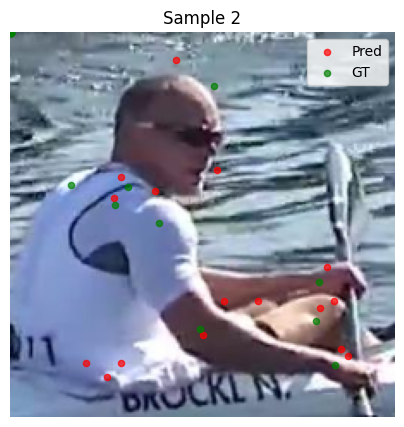

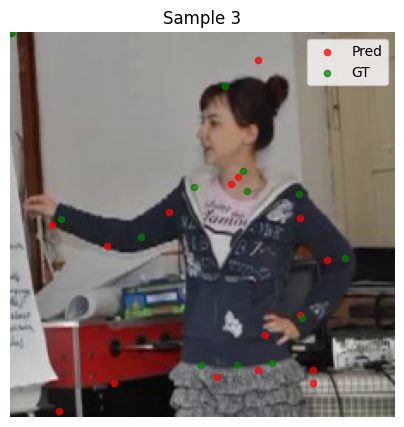

(0.0019854914261183392, 0.7236928789602922)

In [7]:
def test_model(model, test_loader, device='cuda', img_size=224, state_dict_url="best_model.pth"):
    # Load checkpoint
    state_dict = torch.hub.load_state_dict_from_url(state_dict_url, map_location=torch.device('cpu'))

    # 🔧 Auto-handle DataParallel "module." prefixes
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v

    model = model.to(device)
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()

    all_preds, all_targets, all_vis = [], [], []
    test_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            imgs = batch['image'].to(device)
            hmaps = batch['heatmaps'].to(device)
            joints = batch['joints'].to(device)
            vis = batch['visibility'].to(device)

            pred = model(imgs)

            # loss
            test_loss += heatmap_mse_loss(pred, hmaps).item()

            # decode coords
            coords = heatmaps_to_coords(pred)

            all_preds.append(coords * img_size)   # back to pixel space
            all_targets.append(joints * img_size)
            all_vis.append(vis)

    # aggregate
    all_preds_t = torch.cat(all_preds, dim=0)
    all_targets_t = torch.cat(all_targets, dim=0)
    all_vis_t = torch.cat(all_vis, dim=0)

    # compute PCKh
    all_preds_np = all_preds_t.cpu().numpy()
    all_targets_np = all_targets_t.cpu().numpy()
    all_vis_np = all_vis_t.cpu().numpy()
    pckh = compute_pckh(all_preds_np, all_targets_np, all_vis_np)

    test_loss /= len(test_loader)
    print(f"✅ Test Loss: {test_loss:.4f}, PCKh@0.5: {pckh:.4f}")

    # visualize a few predictions
    visualize_batch_predictions(model, test_loader, device=device, img_size=img_size, n_samples=3)

    return test_loss, pckh


device = "cuda" if torch.cuda.is_available() else "cpu"

model = ViTPoseHeatmap(vit_name="vit_small_patch16_224")

model = model.to(device)

test_dataset = MPIIDataset('data/annotations/test_annotations_full.json', 'data/cropped_persons')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

test_model(model, test_loader, device=device, img_size=224, state_dict_url='https://huggingface.co/shai-hulud/AIML339Capstone/resolve/main/vit_small_lora_20e_5e-4.pth')